In [195]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import matplotlib.pyplot as plt
import json

# torch setup
os.environ['TORCH_HOME'] = 'models/torch'

Helper functions:

In [116]:
def load_metrics(file_paths):
    all_metrics = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        # Exclude the last row which contains the epoch average
        df = df[:-1]
        all_metrics.append(df)
    return all_metrics

def plot_histograms(metrics_list, labels, columns_to_plot):
    fig, axs = plt.subplots(1, len(columns_to_plot), figsize=(7, 3), sharey=True)
    
    for ax, column, title in zip(axs, columns_to_plot, ["Loss Histogram", "IOU Histogram"]):
        min_val = min(metrics[column].min() for metrics in metrics_list)
        max_val = max(metrics[column].max() for metrics in metrics_list)
        bins = np.linspace(min_val, max_val, 30)
        
        for metrics, label in zip(metrics_list, labels):
            sns.histplot(metrics[column],  label=label, alpha=0.5, ax=ax, bins=bins)
        ax.set_title(title)
        ax.set_xlabel('Metric Value')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True)
       # ax.set_aspect('equal', 'box')
    
    plt.tight_layout()
    plt.show()
    
    

def calculate_epoch_metrics(metrics_list, labels, columns_to_plot):
    epoch_metrics = []
    for metrics, label in zip(metrics_list, labels):
        means = metrics[columns_to_plot].mean()
        percentiles_75 = metrics[columns_to_plot].quantile(0.75)
        percentiles_90 = metrics[columns_to_plot].quantile(0.90)
        
        row = {
            'label': label,
            'average loss': means['test_image_loss'],
            '75th percentile loss': percentiles_75['test_image_loss'],
            '90th percentile loss': percentiles_90['test_image_loss'],
            'average iou': means['test_image_iou'],
            '75th percentile iou': percentiles_75['test_image_iou'],
            '90th percentile iou': percentiles_90['test_image_iou']
        }
        epoch_metrics.append(row)
    
    return pd.DataFrame(epoch_metrics)


In [270]:
def display_images_side_by_side(folder_paths, image_names, column_names):
    num_images = len(image_names)
    num_folders = len(folder_paths)
    
    fig, axes = plt.subplots(num_images, num_folders, figsize=(3 * num_folders, 3 * num_images))
    
    for i, image_name in enumerate(image_names):
        for j, folder_path in enumerate(folder_paths):
            image_path = os.path.join(folder_path, image_name)
            if os.path.exists(image_path):
                image = Image.open(image_path)
                axes[i, j].imshow(image)
                axes[i, j].axis('off')
                if i == 0:  # Set column names only for the first row
                    axes[i, j].set_title(column_names[j], fontsize=16)
            else:
                axes[i, j].text(0.5, 0.5, 'Image not found', fontsize=8, ha='center')
                axes[i, j].axis('off')

        # Annotate the left side of each row with the image name
        fig.text(0.02, 1 - (i + 0.5) / num_images, image_name, ha='center', va='center', rotation='vertical', fontsize=10)
    
    plt.subplots_adjust(wspace=0.025, hspace=0.025)  # Adjust spacing between subplots
    plt.tight_layout(rect=[0.05, 0, 1, 1])  # Make room for the annotations
    plt.show()

#### Transformation evaluation

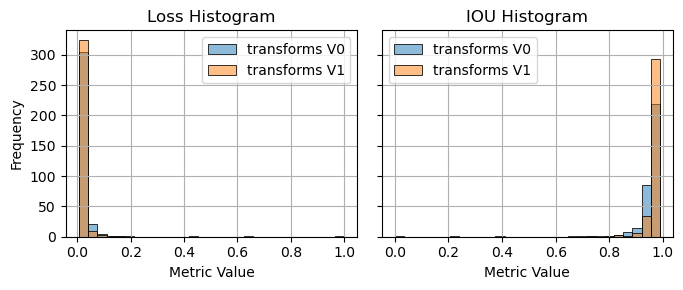

In [125]:
# Explicitly specify the paths to CSV files
csv_files = [
    'logs/Unet_resnet34_pretrained_Tv1_DiceLoss/test/20_epochs/metrics.csv',
    'logs/Unet_resnet34_pretrained_Tv0_DiceLoss/test/metrics.csv'
]

# Specify the columns to plot
columns_to_plot = ['test_image_loss', 'test_image_iou']

# Specify the labels for the plots
labels = ["transforms V0", "transforms V1"]

# Load the metrics
metrics_list = load_metrics(csv_files)

# Plot the histograms
plot_histograms(metrics_list, labels, columns_to_plot)

In [126]:
# Calculate the mean, 75th percentile, and 90th percentile of the specified metrics for each CSV file
epoch_metrics_df = calculate_epoch_metrics(metrics_list, labels, columns_to_plot)

# Set the label as the index
epoch_metrics_df.set_index('label', inplace=True)

# Display the summary table with 3 decimal points
latex_table = epoch_metrics_df.round(3).to_latex(index=True, caption="Summary of Epoch-Level Metrics", label="tab:epoch_metrics")
print(latex_table)

\begin{table}
\caption{Summary of Epoch-Level Metrics}
\label{tab:epoch_metrics}
\begin{tabular}{lrrrrrr}
\toprule
 & average loss & 75th percentile loss & 90th percentile loss & average iou & 75th percentile iou & 90th percentile iou \\
label &  &  &  &  &  &  \\
\midrule
transforms V0 & 0.031000 & 0.026000 & 0.040000 & 0.945000 & 0.970000 & 0.975000 \\
transforms V1 & 0.019000 & 0.021000 & 0.029000 & 0.966000 & 0.978000 & 0.982000 \\
\bottomrule
\end{tabular}
\end{table}



Looking for image at: H:\Cataract Dataset\FSR Dataset\Yolo_Segmentation_640x640/infer/Unet_resnet34_pretrained_Tv0_DiceLoss\test_140.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Yolo_Segmentation_640x640\infer\Unet_resnet34_pretrained_Tv1_DiceLoss\test_140.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Yolo_Segmentation_640x640/infer/Unet_resnet34_pretrained_Tv0_DiceLoss\test_33.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Yolo_Segmentation_640x640\infer\Unet_resnet34_pretrained_Tv1_DiceLoss\test_33.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Yolo_Segmentation_640x640/infer/Unet_resnet34_pretrained_Tv0_DiceLoss\test_213.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Yolo_Segmentation_640x640\infer\Unet_resnet34_pretrained_Tv1_DiceLoss\test_213.png


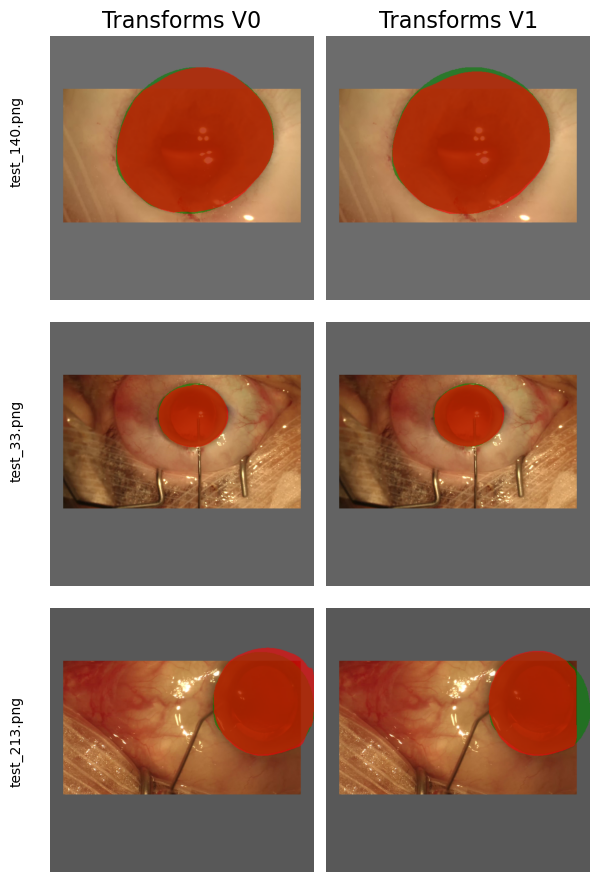

In [127]:
folder_paths = [
    'H:\\Cataract Dataset\\FSR Dataset\\Yolo_Segmentation_640x640/infer/Unet_resnet34_pretrained_Tv0_DiceLoss',
    'H:\\Cataract Dataset\\FSR Dataset\\Yolo_Segmentation_640x640\\infer\\Unet_resnet34_pretrained_Tv1_DiceLoss'
]

image_names = [
    'test_140.png',
    'test_33.png',
    'test_213.png'
]

column_names = [
    'Transforms V0',
    'Transforms V1',
]

display_images_side_by_side(folder_paths, image_names, column_names)

Looking for image at: H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv0_DiceLoss\test_00004499_000008998_61714.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv1_DiceLoss\test_00004499_000008998_61714.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv0_DiceLoss\test_00005499_000010998_34668.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv1_DiceLoss\test_00005499_000010998_34668.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv0_DiceLoss\test_00055744_000092999_53112.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv1_DiceLoss\test_00055744_000092999_53112.png


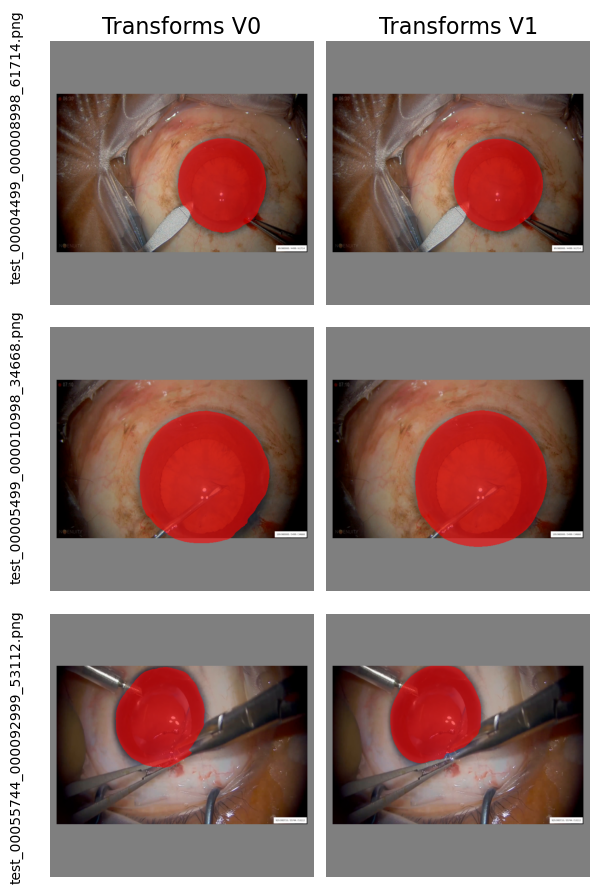

In [121]:
folder_paths = [
    r"H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv0_DiceLoss",
    r"H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv1_DiceLoss"
]

image_names = [
    'test_00004499_000008998_61714.png',
    'test_00005499_000010998_34668.png',
    'test_00055744_000092999_53112.png'
]

column_names = [
    'Transforms V0',
    'Transforms V1',
]

display_images_side_by_side(folder_paths, image_names, column_names)

#### Loss Evaluation

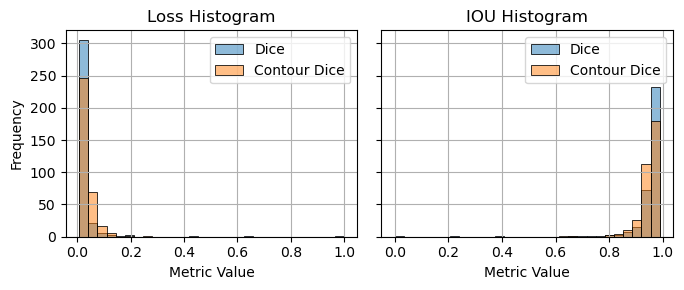

In [137]:
# Explicitly specify the paths to CSV files
csv_files = [
    'logs/Unet_resnet34_pretrained_Tv1_DiceLoss/test/20_epochs/metrics.csv',
    'logs/Unet_resnet34_pretrained_Tv1_CountourDiceLoss/test/test_new_dice/metrics.csv'
]

# Specify the columns to plot
columns_to_plot = ['test_image_loss', 'test_image_iou']

# Specify the labels for the plots
labels = ["Dice", "Contour Dice"]

# Load the metrics
metrics_list = load_metrics(csv_files)

# Plot the histograms
plot_histograms(metrics_list, labels, columns_to_plot)

In [141]:
# Calculate the mean, 75th percentile, and 90th percentile of the specified metrics for each CSV file
epoch_metrics_df = calculate_epoch_metrics(metrics_list, labels, columns_to_plot)

# Set the label as the index
epoch_metrics_df.set_index('label', inplace=True)

# Display the summary table with 3 decimal points
latex_table = epoch_metrics_df.round(3).to_latex(index=True, caption="Summary of Epoch-Level Metrics", label="tab:epoch_metrics",float_format="%.3f")
print(latex_table)

\begin{table}
\caption{Summary of Epoch-Level Metrics}
\label{tab:epoch_metrics}
\begin{tabular}{lrrrrrr}
\toprule
 & average loss & 75th percentile loss & 90th percentile loss & average iou & 75th percentile iou & 90th percentile iou \\
label &  &  &  &  &  &  \\
\midrule
Dice & 0.031 & 0.026 & 0.040 & 0.945 & 0.970 & 0.975 \\
Contour Dice & 0.039 & 0.045 & 0.070 & 0.946 & 0.972 & 0.977 \\
\bottomrule
\end{tabular}
\end{table}



Looking for image at: H:\Cataract Dataset\FSR Dataset\Yolo_Segmentation_640x640\infer\Unet_resnet34_pretrained_Tv1_DiceLoss\test_161.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Yolo_Segmentation_640x640/infer/Unet_resnet34_pretrained_Tv1_CountourDiceLoss\test_161.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Yolo_Segmentation_640x640\infer\Unet_resnet34_pretrained_Tv1_DiceLoss\test_13.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Yolo_Segmentation_640x640/infer/Unet_resnet34_pretrained_Tv1_CountourDiceLoss\test_13.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Yolo_Segmentation_640x640\infer\Unet_resnet34_pretrained_Tv1_DiceLoss\test_248.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Yolo_Segmentation_640x640/infer/Unet_resnet34_pretrained_Tv1_CountourDiceLoss\test_248.png


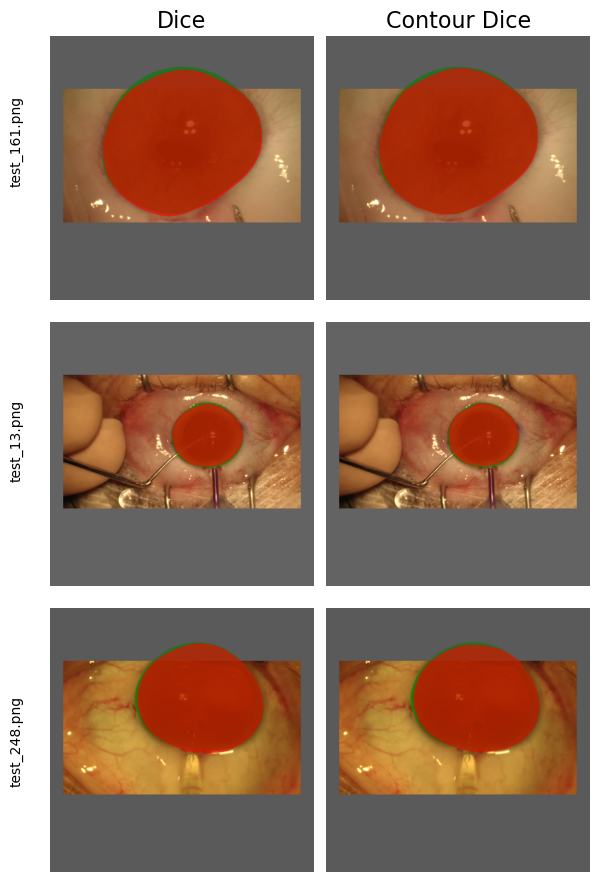

In [146]:
folder_paths = [
    'H:\\Cataract Dataset\\FSR Dataset\\Yolo_Segmentation_640x640\\infer\\Unet_resnet34_pretrained_Tv1_DiceLoss',
    'H:\\Cataract Dataset\\FSR Dataset\\Yolo_Segmentation_640x640/infer/Unet_resnet34_pretrained_Tv1_CountourDiceLoss'
]

image_names = [
    'test_161.png',
    'test_13.png',
    'test_248.png'
]

column_names = [
    'Dice',
    'Contour Dice',
]

display_images_side_by_side(folder_paths, image_names, column_names)

Looking for image at: H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv1_DiceLoss\test_00007792_000012999_29412.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv1_CountourDiceLoss\test_00007792_000012999_29412.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv1_DiceLoss\test_00048499_000096998_02264.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv1_CountourDiceLoss\test_00048499_000096998_02264.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv1_DiceLoss\test_00018581_000030999_36777.png
Looking for image at: H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv1_CountourDiceLoss\test_00018581_000030999_36777.png


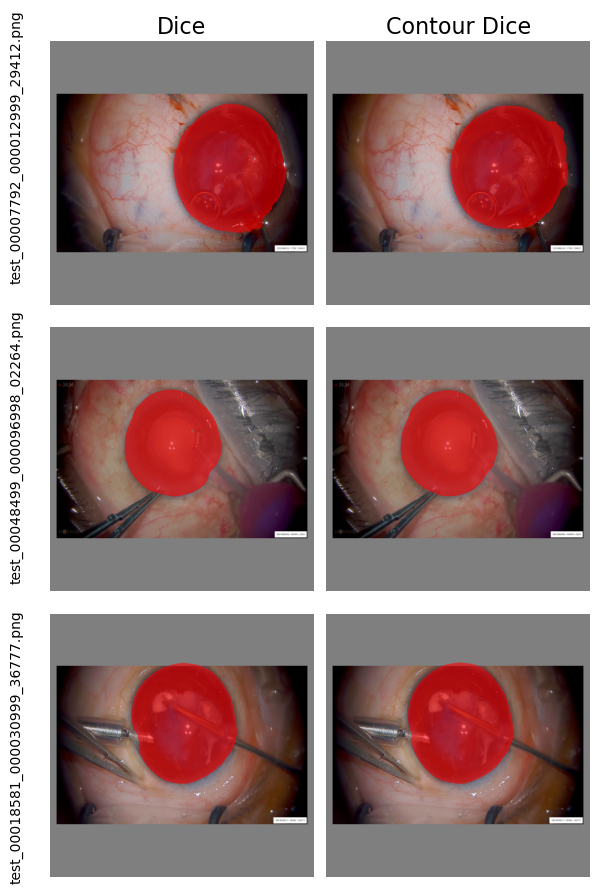

In [152]:
folder_paths = [
    r"H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv1_DiceLoss",
    r"H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer\Unet_resnet34_pretrained_Tv1_CountourDiceLoss"
]

image_names = [
    'test_00007792_000012999_29412.png',
    'test_00048499_000096998_02264.png',
    'test_00018581_000030999_36777.png'
]

column_names = [
    'Dice',
    'Contour Dice'
]

display_images_side_by_side(folder_paths, image_names, column_names)

#### Convergance

In [156]:
# Load the first CSV file
df1 = pd.read_csv(r'logs\Unet_resnet34_pretrained_Tv1_DiceLoss\10_epochs\metrics.csv')

# Load the second CSV file
# Replace 'path/to/second/csv' with the actual path
df2 = pd.read_csv(r'logs\Unet_resnet34_pretrained_Tv1_DiceLoss\20_epochs\metrics.csv')
df2['epoch'] = df2.index + 10  # Add epoch column starting from 10

# Concatenate the dataframes
df_combined = pd.concat([df1, df2], ignore_index=True)

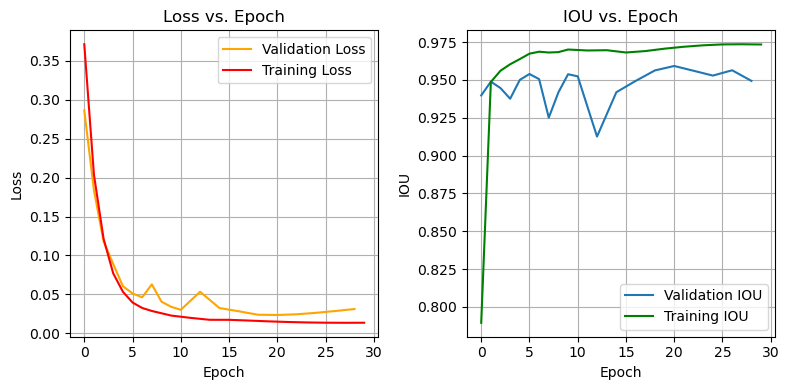

In [163]:
# Drop rows where all relevant columns are NaN
df_combined = df_combined.dropna(how='all', subset=['valid_dataset_iou', 'valid_dataset_loss', 'train_dataset_iou', 'train_dataset_loss'])

# Extract relevant columns and drop NaNs for each metric
epochs = df_combined['epoch']
valid_iou = df_combined['valid_dataset_iou'].dropna()
valid_loss = df_combined['valid_dataset_loss'].dropna()
train_iou = df_combined['train_dataset_iou'].dropna()
train_loss = df_combined['train_dataset_loss'].dropna()

# Extract epochs for valid and train datasets separately
valid_epochs = df_combined['epoch'][df_combined['valid_dataset_iou'].notna()]
train_epochs = df_combined['epoch'][df_combined['train_dataset_iou'].notna()]

# Plot loss vs. epoch
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(valid_epochs, valid_loss, label='Validation Loss', color='orange')
plt.plot(train_epochs, train_loss, label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid()

# Plot IOU vs. epoch
plt.subplot(1, 2, 2)
plt.plot(valid_epochs, valid_iou, label='Validation IOU')
plt.plot(train_epochs, train_iou, label='Training IOU', color='green')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.title('IOU vs. Epoch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


### Model Comparison table

In [224]:
from models.smp_model import CatSegModel

def load_json_files(file_paths):
    data_list = []
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            data = json.load(file)
            data_list.append(data)
    return data_list

def create_comparison_table(data_list, checkpoint_path):
    comparison_data = []
    for i, data in enumerate(data_list, start=1):
        checkpoint_file = os.path.join(checkpoint_path, data['NAME'], f"{data['NAME']}_best-checkpoint.ckpt")
        hparams_file = os.path.join(checkpoint_path, 'hparams.yaml')
        model = CatSegModel.load_from_checkpoint(
            checkpoint_path=checkpoint_file,
            #hparams_file=hparams_file
        )
        
        num_params = compute_num_params(model)
        print(num_params)
        
        comparison_data.append({
            "arch": data.get("ARCH", ""),
            "encoder": data.get("ENCODER", ""),
            "encoder_weights": data.get("ENCODER_WEIGHTS", ""),
            "loss": data.get("LOSS", ""),
            "LR": data.get("LR", ""),
            "Parameters": num_params
        })
    
    df = pd.DataFrame(comparison_data)
    df['Parameters'] = df['Parameters'].astype(float)
    
    return df

def compute_num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [225]:
file_paths = [
    r'configs\Unet_resnet34_train.json',
    r'configs\Unet_efficientnet-b2_train.json',
    r'configs\Unet_efficientnet-b3_train.json',
    r'configs\Unetpp_resnext50_32x4d_train.json',
    #r'configs\Unetpp_mobilenetv3_large_100_train_.json',
    #r'configs\FPN_resnet50_train.json',
    r'configs\DeepLabV3Plus_resnext101_32x8d_train.json'
]

checkpoint_path = r'H:\Cataract Dataset\Model Checkpoints'

data_list = load_json_files(file_paths)
comparison_table = create_comparison_table(data_list, checkpoint_path)


24436369
10046291
13159033
48457617
89911889


In [226]:
latex_table = comparison_table.to_latex(index=True, caption="Models Overview", label="tab:modelcompare", float_format='{:.2E}'.format)
print(latex_table)

\begin{table}
\caption{Models Overview}
\label{tab:modelcompare}
\begin{tabular}{lllllrr}
\toprule
 & arch & encoder & encoder_weights & loss & LR & Parameters \\
\midrule
0 & Unet & resnet34 & imagenet & DiceLoss & 1.00E-04 & 2.44E+07 \\
1 & Unet & efficientnet-b2 & imagenet & DiceLoss & 5.00E-05 & 1.00E+07 \\
2 & Unet & efficientnet-b3 & imagenet & DiceLoss & 1.00E-04 & 1.32E+07 \\
3 & UnetPlusPlus & resnext50_32x4d & imagenet & DiceLoss & 1.00E-04 & 4.85E+07 \\
4 & DeepLabV3Plus & resnext101_32x8d & swsl & DiceLoss & 1.00E-04 & 8.99E+07 \\
\bottomrule
\end{tabular}
\end{table}



#### Models validation dataset

In [232]:
def generate_csv_files(configs):
    csv_files = []
    for config in configs:
        name = config.get("NAME", "")
        if name:
            csv_path = os.path.join('logs', name, 'test', 'metrics.csv')
            csv_files.append(csv_path)
    return csv_files

csv_files = generate_csv_files(data_list)
print(csv_files)

['logs\\Unet_resnet34_pretrained_Tv1_DiceLoss\\test\\metrics.csv', 'logs\\Unet_efficientnet-b2_pretrained_Tv1_DiceLoss\\test\\metrics.csv', 'logs\\Unet_efficientnet-b3_pretrained_Tv0_DiceLoss\\test\\metrics.csv', 'logs\\Unetpp_resnext50_32x4d_pretrained_Tv0_DiceLoss\\test\\metrics.csv', 'logs\\DeepLabV3Plus_resnext101_32x8d_pretrained_Tv1_DiceLoss\\test\\metrics.csv']


In [237]:
# Calculate the mean, 75th percentile, and 90th percentile of the specified metrics for each CSV file
epoch_metrics_df = calculate_epoch_metrics(metrics_list, labels, columns_to_plot)

# Set the label as the index
epoch_metrics_df.set_index('label', inplace=True)

# Display the summary table with 3 decimal points
latex_table = epoch_metrics_df.round(3).to_latex(index=True, caption="Summary of Epoch-Level Metrics", label="tab:epoch_metrics", float_format="%.3f")
print(latex_table)

\begin{table}
\caption{Summary of Epoch-Level Metrics}
\label{tab:epoch_metrics}
\begin{tabular}{lrrrrrr}
\toprule
 & average loss & 75th percentile loss & 90th percentile loss & average iou & 75th percentile iou & 90th percentile iou \\
label &  &  &  &  &  &  \\
\midrule
Unet_resnet34_pretrained_Tv1_DiceLoss & 0.031 & 0.026 & 0.040 & 0.945 & 0.970 & 0.975 \\
Unet_efficientnet-b2_pretrained_Tv1_DiceLoss & 0.024 & 0.029 & 0.039 & 0.953 & 0.972 & 0.978 \\
Unet_efficientnet-b3_pretrained_Tv0_DiceLoss & 0.013 & 0.015 & 0.020 & 0.976 & 0.985 & 0.987 \\
Unetpp_resnext50_32x4d_pretrained_Tv0_DiceLoss & 0.015 & 0.018 & 0.023 & 0.971 & 0.981 & 0.985 \\
DeepLabV3Plus_resnext101_32x8d_pretrained_Tv1_DiceLoss & 0.026 & 0.022 & 0.035 & 0.956 & 0.978 & 0.983 \\
\bottomrule
\end{tabular}
\end{table}



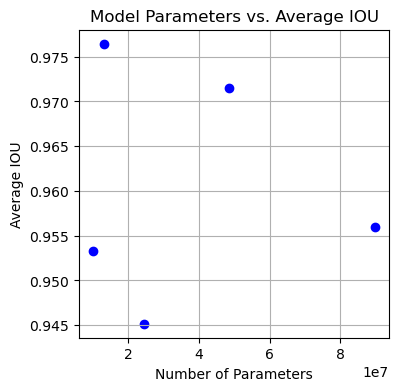

In [255]:
plt.figure(figsize=(4, 4))
plt.scatter(comparison_table['Parameters'], epoch_metrics_df.loc[:,'average iou'], color='blue')
plt.xlabel('Number of Parameters')
plt.ylabel('Average IOU')
plt.title('Model Parameters vs. Average IOU')
plt.grid(True)
plt.show()

#### Generate model images

In [ ]:
valid_path= r'H:\\Cataract Dataset\\FSR Dataset\\Yolo_Segmentation_640x640\\infer'

folder_paths = [os.path.join(valid_path, data['NAME']) for data in data_list]

image_names = [
    'test_161.png',
    'test_13.png',
    'test_7.png',
    'test_147.png',
    'test_89.png'
]

column_names = [
    'U-net_ResNet34',
    'U-net_EfficientNet-b2',
    'U-net_EfficientNet-b3',
    'U-net++_ResNeXt50',
    'DeepLabV3+_ResNeXt101'
]


display_images_side_by_side(folder_paths, image_names, column_names)

In [281]:
folder_paths

['H:\\Cataract Dataset\\FSR Dataset\\Ori_youtube_20_infer\\Unet_resnet34_pretrained_Tv1_DiceLoss',
 'H:\\Cataract Dataset\\FSR Dataset\\Ori_youtube_20_infer\\Unet_efficientnet-b2_pretrained_Tv1_DiceLoss',
 'H:\\Cataract Dataset\\FSR Dataset\\Ori_youtube_20_infer\\Unet_efficientnet-b3_pretrained_Tv0_DiceLoss',
 'H:\\Cataract Dataset\\FSR Dataset\\Ori_youtube_20_infer\\Unetpp_resnext50_32x4d_pretrained_Tv0_DiceLoss',
 'H:\\Cataract Dataset\\FSR Dataset\\Ori_youtube_20_infer\\DeepLabV3Plus_resnext101_32x8d_pretrained_Tv1_DiceLoss']

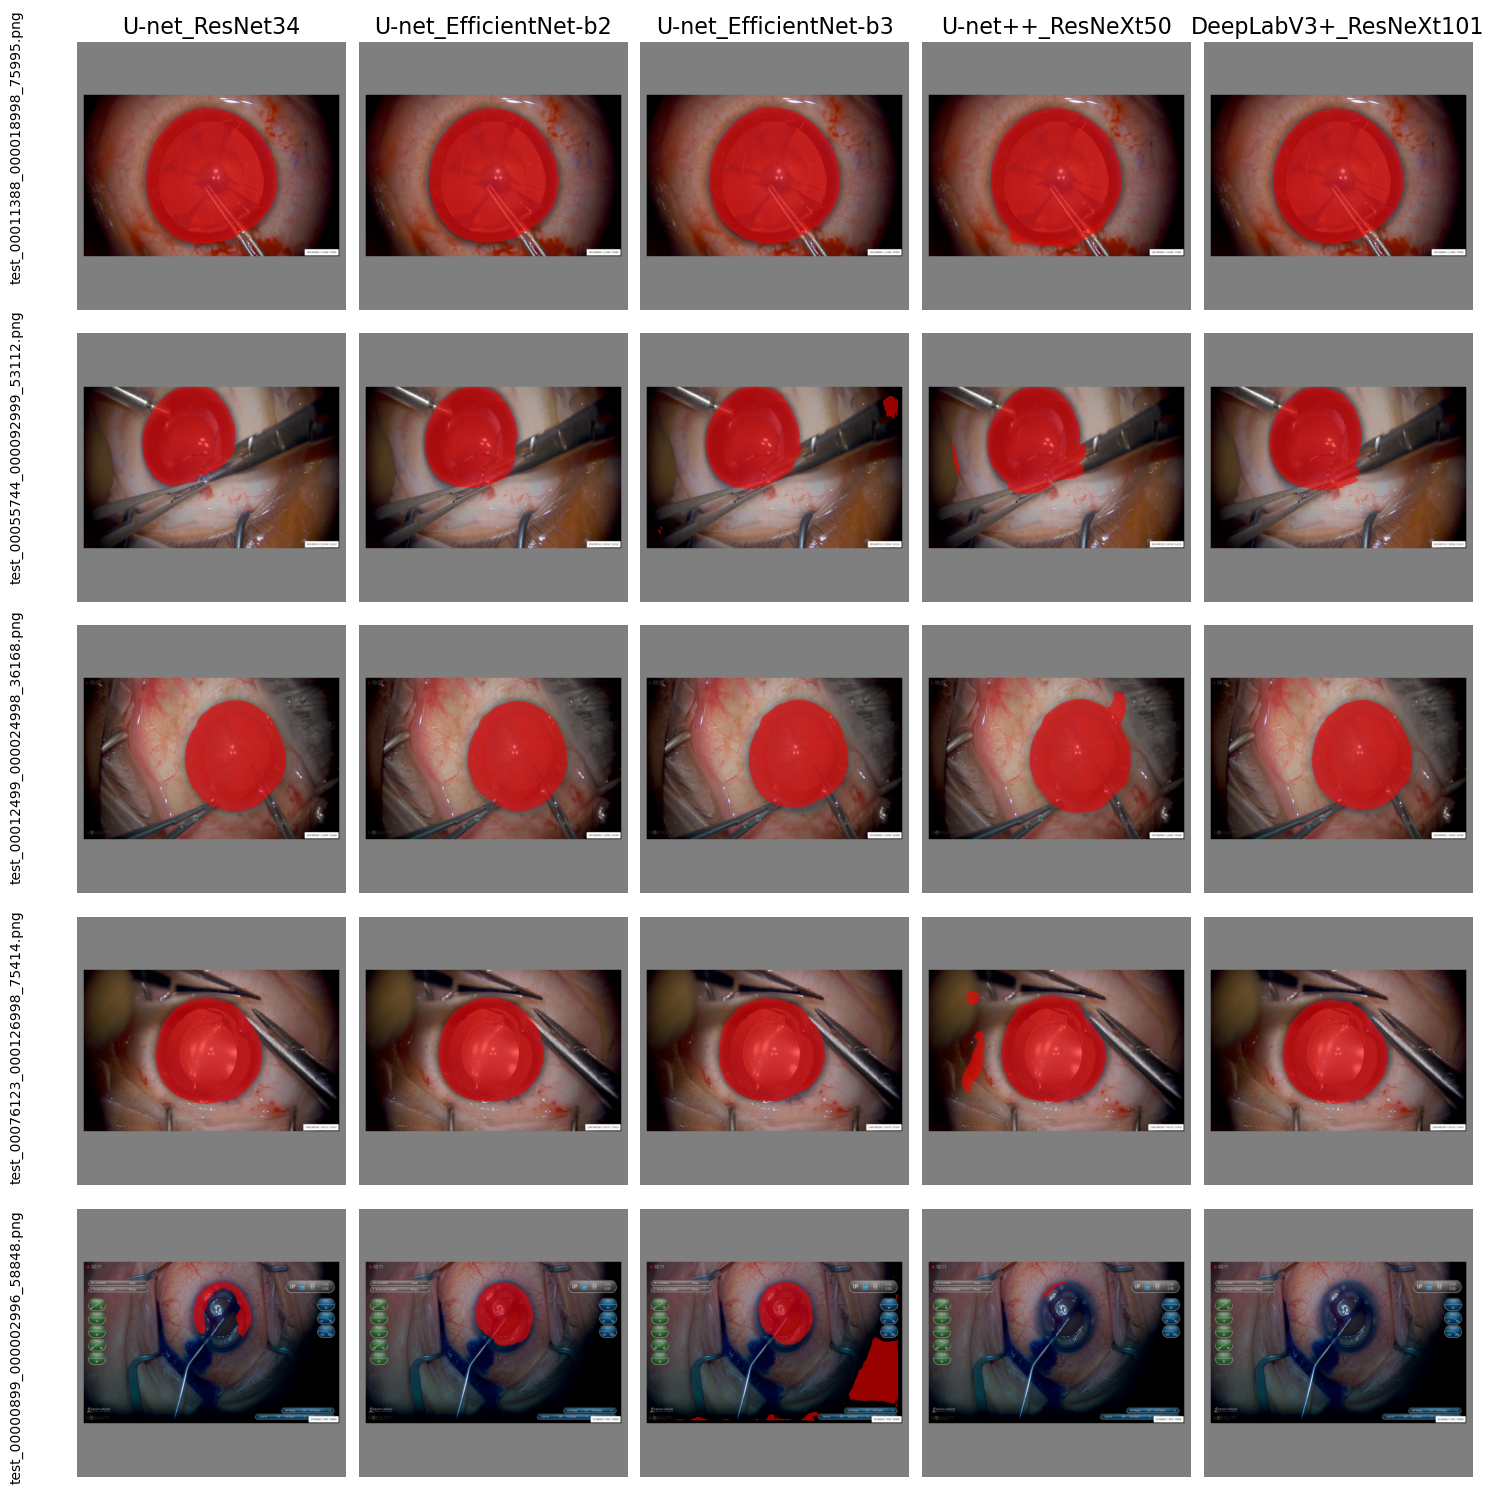

In [283]:
infer_path= r'H:\Cataract Dataset\FSR Dataset\Ori_youtube_20_infer'
folder_paths = [os.path.join(infer_path, data['NAME']) for data in data_list]

image_names = [
    'test_00011388_000018998_75995.png',
    'test_00055744_000092999_53112.png',
    'test_00012499_000024998_36168.png',
    'test_00076123_000126998_75414.png',
    'test_00000899_000002996_58848.png'
]

column_names = [
    'U-net_ResNet34',
    'U-net_EfficientNet-b2',
    'U-net_EfficientNet-b3',
    'U-net++_ResNeXt50',
    'DeepLabV3+_ResNeXt101'
]


display_images_side_by_side(folder_paths, image_names, column_names)

#### Timing methodology